<a href="https://colab.research.google.com/github/shruthisundar123/OctMNIST-Image-Classification/blob/main/MedMNIST_3_Finally_got_it_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports and Loading

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from skimage.transform import resize
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_URL = 'https://zenodo.org/record/4269852/files/octmnist.npz?download=1'
path = tf.keras.utils.get_file('octmnist.npz', DATA_URL)
data = np.load(path)

54943744/54938180 [==============================] - 4s 0us/step


In [ ]:
print(data['train_images'].shape)

(97477, 28, 28)


In [ ]:
train_images_rgb = np.repeat(data['train_images'][..., np.newaxis], 3, -1)
val_images_rgb = np.repeat(data['val_images'][..., np.newaxis], 3, -1)
test_images_rgb = np.repeat(data['test_images'][..., np.newaxis], 3, -1)

In [ ]:
print(train_images_rgb.shape)
print(val_images_rgb.shape)
print(test_images_rgb.shape)

(97477, 28, 28, 3)
(10832, 28, 28, 3)
(1000, 28, 28, 3)


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


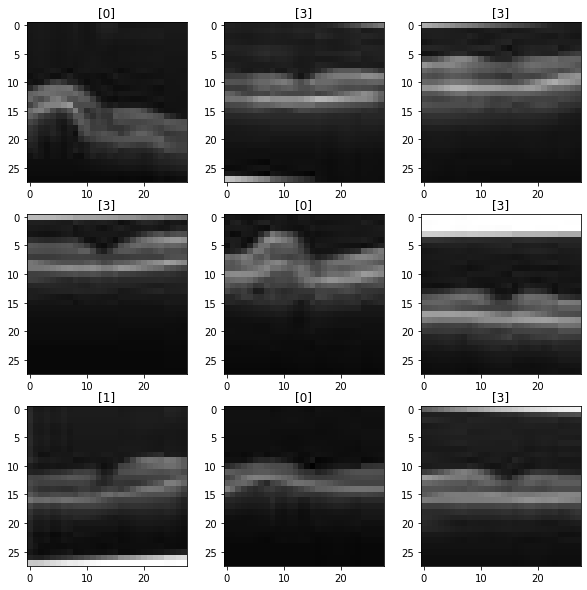

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(train_images_rgb[i])
  plt.title(data['train_labels'][i])

In [ ]:
# # one hot encoding labels
# train_labels_oh = tf.one_hot(data['train_labels'], depth=4)
# val_labels_oh = tf.one_hot(data['val_labels'], depth=4)
# test_labels_oh = tf.one_hot(data['test_labels'], depth=4)
# # didn't work - why?

In [ ]:
train_labels_oh = keras.utils.to_categorical(data['train_labels'], 4)
val_labels_oh = keras.utils.to_categorical(data['val_labels'], 4)
test_labels_oh = keras.utils.to_categorical(data['test_labels'], 4)

In [ ]:
print(data['train_labels'].shape)
print(train_labels_oh.shape)

(97477, 1)
(97477, 4)


##Dataset

In [ ]:
# creating datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images_rgb[0:5000], train_labels_oh[0:5000]))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images_rgb[0:5000], val_labels_oh[0:5000]))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images_rgb[0:1000], test_labels_oh[0:1000]))

In [ ]:
#resize images to 32,32

size = (32, 32)

train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(x, size), y))
val_dataset = val_dataset.map(lambda x, y: (tf.image.resize(x, size), y))
test_dataset = test_dataset.map(lambda x, y: (tf.image.resize(x, size), y))

train_size = train_dataset.cardinality().numpy()
val_size = val_dataset.cardinality().numpy()

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

##Model

In [ ]:
# base_model = tf.keras.applications.Xception(weights='imagenet',  input_shape=(150, 150, 3),  include_top=False)

base_model = tf.keras.applications.ResNet50(input_shape=(32, 32, 3),
                                               include_top=False,
                                               weights='imagenet')

# # Freeze base model
base_model.trainable = False

In [ ]:
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#   tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
# ])

In [ ]:
image_batch, label_batch = next(iter(train_dataset))

feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1, 1, 2048)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [ ]:
prediction_layer = tf.keras.layers.Dense(4, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [ ]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [ ]:
inputs = keras.Input(shape=(32, 32, 3))
# x = data_augmentation(inputs)

# norm_layer = keras.layers.experimental.preprocessing.Normalization()
# mean = np.array([127.5] * 3)
# var = mean ** 2
# # Scale inputs to [-1, +1]
# x = norm_layer(x)
# norm_layer.set_weights([mean, var])

x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = prediction_layer(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem_5 ( (None, 32, 32, 3)         0         
_________________________________________________________________
tf.nn.bias_add_5 (TFOpLambda (None, 32, 32, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 8196

In [ ]:
#train the top layer

# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.9)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.1),
    metrics=['accuracy'],
)

# model.compile(
#     optimizer=keras.optimizers.SGD(lr=0.005, momentum=0.9),
#     loss=keras.losses.SparseCategoricalCrossentropy(
#       from_logits=False, name='sparse_categorical_crossentropy'),
#     metrics=['accuracy']
# )


In [ ]:
epochs = 30
hist = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

Epoch 1/30
157/157 [==============================] - 8s 35ms/step - loss: 2.1758 - accuracy: 0.4532 - val_loss: 1.2940 - val_accuracy: 0.6284
Epoch 2/30
157/157 [==============================] - 5s 29ms/step - loss: 1.6377 - accuracy: 0.5620 - val_loss: 1.1578 - val_accuracy: 0.6720
Epoch 3/30
157/157 [==============================] - 5s 29ms/step - loss: 1.4536 - accuracy: 0.6050 - val_loss: 1.1011 - val_accuracy: 0.6872
Epoch 4/30
157/157 [==============================] - 5s 29ms/step - loss: 1.3990 - accuracy: 0.6104 - val_loss: 1.0504 - val_accuracy: 0.6988
Epoch 5/30
157/157 [==============================] - 5s 29ms/step - loss: 1.3237 - accuracy: 0.6254 - val_loss: 1.0192 - val_accuracy: 0.7042
Epoch 6/30
157/157 [==============================] - 5s 29ms/step - loss: 1.2764 - accuracy: 0.6416 - val_loss: 1.0065 - val_accuracy: 0.7152
Epoch 7/30
157/157 [==============================] - 5s 30ms/step - loss: 1.2194 - accuracy: 0.6496 - val_loss: 0.9816 - val_accuracy: 0.7158

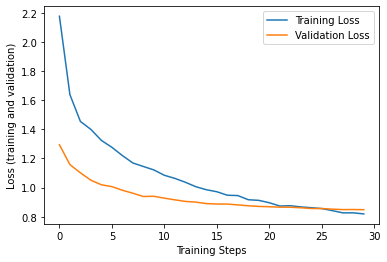

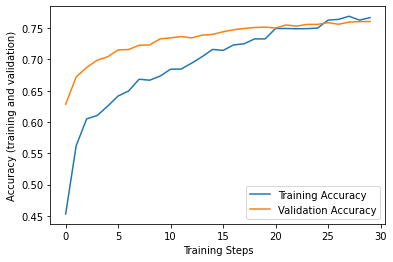

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.plot(hist.history["loss"], label='Training Loss')
plt.plot(hist.history["val_loss"], label='Validation Loss')
plt.legend(loc='upper right')

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.plot(hist.history["accuracy"], label='Training Accuracy')
plt.plot(hist.history["val_accuracy"], label='Validation Accuracy')
plt.legend(loc='lower right')

## Fine Tuning

In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.1),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001),
              metrics=['accuracy'])

In [ ]:
len(model.trainable_variables)


92

In [ ]:
fine_tune_epochs = 10
total_epochs =  epochs + fine_tune_epochs

hist_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=hist.epoch[-1],
                         validation_data=val_dataset)

Epoch 30/40
157/157 [==============================] - 17s 63ms/step - loss: 0.8158 - accuracy: 0.7722 - val_loss: 0.8365 - val_accuracy: 0.7712
Epoch 31/40
157/157 [==============================] - 9s 55ms/step - loss: 0.7377 - accuracy: 0.8106 - val_loss: 0.8186 - val_accuracy: 0.7806
Epoch 32/40
157/157 [==============================] - 8s 52ms/step - loss: 0.6815 - accuracy: 0.8448 - val_loss: 0.8246 - val_accuracy: 0.7850
Epoch 33/40
157/157 [==============================] - 8s 52ms/step - loss: 0.6387 - accuracy: 0.8672 - val_loss: 0.8240 - val_accuracy: 0.7854
Epoch 34/40
157/157 [==============================] - 9s 54ms/step - loss: 0.6069 - accuracy: 0.8816 - val_loss: 0.8222 - val_accuracy: 0.7860
Epoch 35/40
157/157 [==============================] - 9s 57ms/step - loss: 0.5788 - accuracy: 0.8984 - val_loss: 0.8238 - val_accuracy: 0.7888
Epoch 36/40
157/157 [==============================] - 9s 56ms/step - loss: 0.5494 - accuracy: 0.9122 - val_loss: 0.8330 - val_accuracy

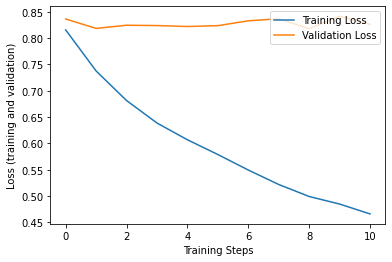

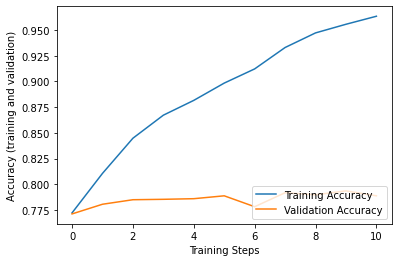

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.plot(hist_fine.history["loss"], label='Training Loss')
plt.plot(hist_fine.history["val_loss"], label='Validation Loss')
plt.legend(loc='upper right')

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.plot(hist_fine.history["accuracy"], label='Training Accuracy')
plt.plot(hist_fine.history["val_accuracy"], label='Validation Accuracy')
plt.legend(loc='lower right')